# Pytorch Audio Emotion Classifier - Neel Patel

# 1. Data Preprocessing

## Go to !End of DataPreprocessing to run the cells before this

In [1]:
# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

#Use GPU acceleration if possible
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
   
print(f'Using {device}') 

# Set seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA

AUGMENTATIONS_LOADED = True

Using cuda


In [2]:
#Import file_path

#Both sex
RAVDESS_path ='/kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'

#Both Sex
Crema_path = '/kaggle/input/speech-emotion-recognition-en/Crema/'
crema_metadata_df = pd.read_csv('/kaggle/input/crema-metadata-extra-information/VideoDemographics.csv')

#Only male
SAVEE_path = '/kaggle/input/speech-emotion-recognition-en/Savee/' 

#Only female
TESS_path = '/kaggle/input/speech-emotion-recognition-en/Tess/'


if os.path.exists('/kaggle/input/metadata-and-augmentations'):

    augmented_dir = '/kaggle/input/metadata-and-augmentations'
    
    augmented_training_df = pd.read_csv(augmented_dir+'/augmented_training_df.csv')
    testing_df = pd.read_csv(augmented_dir+'/testing_df.csv')

    AUGMENTATIONS_LOADED = True
    os.chdir(augmented_dir)
    print('Successfully loaded previous augmentations')

else:
    AUGMENTATIONS_LOADED = False
    print('Go to !End of DataPreprocessing cell in table of contents to run the cells before this in order to get dataaugmentations')

# AUGMENTATIONS_LOADED = False
# os.chdir('/kaggle/working/')

Successfully loaded previous augmentations


In [3]:
#crema_metadata_df.loc[crema_metadata_df['Ethnicity'] == 'Hispanic']
crema_metadata_df.loc[crema_metadata_df['ActorID'] == 1013]

,ActorID,Age,Sex,Race,Ethnicity
12,1013,22,Female,Caucasian,Hispanic


In [4]:
def RAVDESS_extractor(audio_dir):
    data_list = []
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    RAV_metadata_df = pd.DataFrame(columns = columns)
    
    # Map identifiers to their corresponding values
    emotion_dict = {
      "01": "neutral", "02": "neutral", "03": "happy", "04": "sad",
      "05": "angry", "06": "fear", "07": "disgust", "08": "surprised"
    }
    
    intensity_dict = {"01": "medium", "02": "high"}
    statement_dict = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}
    
    
    data_list = []
    for actor_folder in os.listdir(audio_dir):
      actor_path = os.path.join(audio_dir, actor_folder)
    
      if os.path.isdir(actor_path):  # Check if it's a folder
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    parts = file.split(".")[0].split("-") #first split the .wav extension then the '-'
    
                    # Extract metadata from the filename
                    modality = parts[0]  # Not used, as it’s audio-only for now
                    vocal_channel = "speech" if parts[1] == "01" else "song"
                    emotion = emotion_dict[parts[2]]
                    emotional_intensity = intensity_dict[parts[3]]
                    statement = statement_dict[parts[4]]
                    actor_id = int(parts[6])
                    gender = "male" if actor_id % 2 != 0 else "female"
                    file_path = os.path.join(actor_path, file)  # Full path to the file
                    
                    # Append to datalist (ignoring the repetition)
                    data_list.append({
                        'Filename': file,
                        'Filepath':file_path,
                        'Gender': gender,
                        'Emotion': emotion,
                        'Emotional Intensity': emotional_intensity
                    })
    
    df_addon = pd.DataFrame(data_list)
    RAV_metadata_df = pd.concat([RAV_metadata_df, df_addon], ignore_index=True)

    return RAV_metadata_df

def CREMA_extractor(audio_dir,crema_metadata_df):
    data_list = []
    emotion_map_dict = {'SAD':'sad',
                       'ANG':'angry',
                       'DIS':'disgust',
                       'FEA':'fear',
                       'HAP':'happy',
                       'NEU':'neutral'}
    intensity_dict = {'LO':'low',
                     'MD':'medium',
                     'HI':'high',
                     'XX':'unknown',
                     'X':'unknown'}

    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    crema_organized_df = pd.DataFrame(columns = columns)
    
    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        actor_id = int(parts[0])

        gender = crema_metadata_df.loc[crema_metadata_df['ActorID'] == actor_id]['Sex'].values[0].lower()
        emotion = emotion_map_dict[parts[2]]

        #debugging
        #print(file_name)
        intensity = intensity_dict[parts[3]]

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    crema_organized_df = pd.concat([crema_organized_df,df_addon],ignore_index=True)
    return crema_organized_df

def SAVEE_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    savee_metadata_df = pd.DataFrame(columns = columns)

    data_list = []
    
    emotion_map_dict = {'sa':'sad',
                       'a':'angry',
                       'd':'disgust',
                       'f':'fear',
                       'h':'happy',
                       'n':'neutral',
                        'su':'surprised'}

    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        gender = 'male'
        
        emotion_code = "".join([s for s in parts[1] if s.isalpha()])
        emotion = emotion_map_dict[emotion_code]
        intensity = 'unknown'

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    savee_metadata_df = pd.concat([savee_metadata_df,df_addon],ignore_index=True)
    return savee_metadata_df

def TESS_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    tess_metadata_df = pd.DataFrame(columns = columns)
    
    emotion_map_dict = {'sad':'sad',
                       'angry':'angry',
                       'disgust':'disgust',
                       'fear':'fear',
                       'happy':'happy',
                       'neutral':'neutral',
                       'ps':'surprised'}
    data_list = []
    
    for folder in os.listdir(audio_dir):
      folder_path = os.path.join(audio_dir, folder)
    
      if os.path.isdir(folder_path):  # Check if it's a folder
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_name = file
                    file_path = os.path.join(folder_path, file)
                    
                    parts = file.split('.')[0].split('_')
                    emotion = emotion_map_dict[parts[2].lower()]
                    intensity = 'unknown'
                    gender = 'female'
                    
                    data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    tess_metadata_df = pd.concat([tess_metadata_df,df_addon],ignore_index=True)
    return tess_metadata_df

In [5]:
# Get all the datasets metadata dataframe
ravdess_metadata_df = RAVDESS_extractor(RAVDESS_path)
crema_organized_df = CREMA_extractor(Crema_path,crema_metadata_df)
savee_metadata_df = SAVEE_extractor(SAVEE_path)
tess_metadata_df = TESS_extractor(TESS_path)


In [6]:
ravdess_metadata_df['Emotion'].unique()
crema_organized_df['Emotion'].unique()
savee_metadata_df['Emotion'].unique()
tess_metadata_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprised', 'happy'],
      dtype=object)

In [7]:
# Combine the metadata for all dataframes!

combined_metadata_df = pd.concat([ravdess_metadata_df,
                                  crema_organized_df,
                                  savee_metadata_df,
                                  tess_metadata_df])

combined_metadata_df.head()

,Filename,Filepath,Gender,Emotion,Emotional Intensity
0,03-01-08-01-01-01-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,surprised,medium
1,03-01-01-01-01-01-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,neutral,medium
2,03-01-07-02-01-02-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,disgust,high
3,03-01-07-01-01-02-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,disgust,medium
4,03-01-01-01-02-01-02.wav,/kaggle/input/speech-emotion-recognition-en/Ra...,female,neutral,medium


Emotion
disgust      1923
sad          1923
fear         1923
happy        1923
angry        1923
neutral      1895
surprised     652
Name: count, dtype: int64

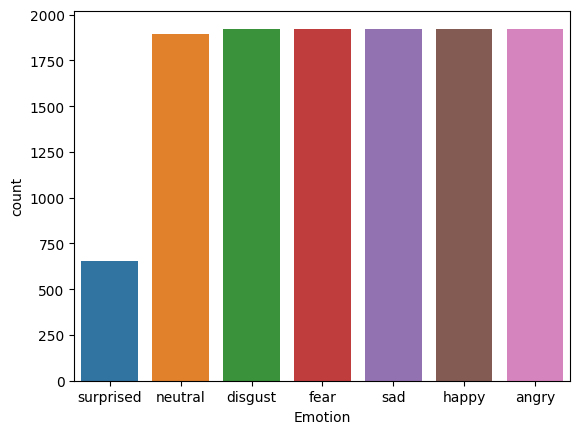

In [8]:
#Exploratory Data Analysis

sns.countplot(data = combined_metadata_df, x = 'Emotion')
combined_metadata_df['Emotion'].value_counts()


**Notice how surprise category is low on numbers! We should perform data augmentation only on the training dataset to avoid data leakage**

The game plan is to:
* 1: Augment data to the surprised category to make it balanced
* 2: Split the data into training and testing datasets
* 3: Augment the training dataset


In [9]:
#Surprised dataframe


surprised_df = combined_metadata_df.loc[combined_metadata_df['Emotion'] == 'surprised']

if AUGMENTATIONS_LOADED == False:
    #Write Augmentation Functions and Helper Functions:
    augmented_dir = "augmented_surprised_samples"
    
    #Delete everyfile in augmented_dirs_folder
    if os.path.exists(augmented_dir):
        shutil.rmtree(augmented_dir) 
    os.makedirs(augmented_dir, exist_ok=True)
    
    
    #set random seed to be 42
    random.seed(42)

def add_white_noise(waveform, 
                    noise_level=np.random.uniform(low =  0.0001,high = 0.001)):
    noise = torch.randn_like(waveform, device = device) * noise_level
    return waveform + noise

def time_stretch(waveform, sample_rate, rate=None):
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    stretched = librosa.effects.time_stretch(waveform_np, rate=rate)
    return torch.tensor(stretched, device = device).unsqueeze(0)  # Convert back to tensor with channel dimension

def pitch_scale(waveform, sample_rate, 
                n_steps=None):
    if n_steps is None:
        n_steps = np.random.uniform(low = -1, high = 1)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    pitched = librosa.effects.pitch_shift(waveform_np, sr=sample_rate, n_steps=n_steps)
    return torch.tensor(pitched, device = device).unsqueeze(0)  # Convert back to tensor with channel dimension

def polarity_inversion(waveform):
    return -waveform

def apply_gain(waveform, gain_factor = np.random.uniform(low = 5, high = 30)):
    gain = torchaudio.transforms.Vol(gain = gain_factor, gain_type = 'amplitude').to(device)
    return gain(waveform)

def apply_augmentations(waveform, sample_rate):
    # List of possible augmentations
    augmentations = [
        lambda x: add_white_noise(x),
        lambda x: time_stretch(x, sample_rate),
        lambda x: pitch_scale(x, sample_rate),
        lambda x: polarity_inversion(x),
        lambda x: apply_gain(x)
    ]
    
    # Randomly choose one or more augmentations to apply
    num_augmentations = 3
    selected_augmentations = random.sample(augmentations, num_augmentations)
    
    for augment in selected_augmentations:
        waveform = augment(waveform)
    return waveform


# Assuming you have a dataframe 'surprised_df' with original "surprised" audio samples
def create_augmented_samples_surprised(surprised_df, new_sample_rate = None):
    augmented_samples = []
    
    for version in range(1,3):
        # First round of augmentation (AugmentedV1)
        for i, row in tqdm(surprised_df.iterrows(), total = len(surprised_df), desc=f"Augmenting Version {version}"):
            file_path = row['Filepath']
            file_name = row['Filename'].split('.')[0]
            
            augmented_file_name = f"{file_name}_surprised_augmentedV{version}_{i}.wav"
            gender = row['Gender']
            emotional_intensity = row['Emotional Intensity']
            
            
            waveform, original_sr = torchaudio.load(file_path)
            waveform = waveform.to(device)
            
            #print(file_name)

            # Ensure waveform is 2D [1, num_samples] if it's mono
            if waveform.ndim > 1:
                waveform = waveform.mean(dim = 0).unsqueeze(0)

            #step1= time.time()
            # Resample if necessary
            if original_sr != new_sample_rate and new_sample_rate is not None:
                resampler = torchaudio.transforms.Resample(original_sr, 
                                                           new_sample_rate,
                                                           lowpass_filter_width=16, 
                                                           resampling_method='sinc_interp_hann').to(device)
                waveform = resampler(waveform)

            #step2= time.time()
            #print(f'Resample time was {step1-step2}')

            
            # Apply augmentations to create the first round of augmented samples
            augmented_waveform = apply_augmentations(waveform, original_sr)

            augmented_waveform = augmented_waveform.cpu()

            # Save augmented sample to a new file
            augmented_file_path = os.path.join(augmented_dir, augmented_file_name)
            torchaudio.save(augmented_file_path, augmented_waveform, original_sr, channels_first = True)

            # Append augmented sample details to the list
            augmented_samples.append({
                'Filename': augmented_file_name,
                'Filepath': augmented_file_path,
                'Gender': gender,
                'Emotion': 'surprised',  # Keep the same emotion label
                'Emotional Intensity': emotional_intensity,
                'Augmentation_Type': f'AugmentedV{version}'  # Tag the augmentation type
            })

    # Convert to DataFrame for compatibility
    augmented_df = pd.DataFrame(augmented_samples)
    return augmented_df



In [10]:
#Save and run the augmentations 
#Augment only the surprised_df to create new samples:

if AUGMENTATIONS_LOADED == False:
    sample_rate = 24414 
    augmented_surprised_df = create_augmented_samples_surprised(surprised_df, 
                                                                new_sample_rate = sample_rate) 
    
    shutil.make_archive('augmented_surprised_samples', 'zip', augmented_dir)
    
    # Download the zip file (if using a Jupyter environment)
    from IPython.display import FileLink
    FileLink('augmented_surprised_samples.zip')

In [11]:
#Combine the augmented surprised with the combined_metadata_df 

if AUGMENTATIONS_LOADED == False:
    combined_metadata_df = pd.concat((combined_metadata_df,
                                      augmented_surprised_df.drop('Augmentation_Type',axis = 1)))
    
    sns.countplot(data = combined_metadata_df, x = 'Emotion')
    combined_metadata_df['Emotion'].value_counts()

In [12]:
#Splitting Training and Testing Data

#gameplan:
#1. Take nonaugmented surprised samples and make those the testing samples
#2. Take the other emotions and create testing and training samples 

# Take nonaugmented surprised data for testing data


#Create function for creating training and testing indices for other emotions
def creating_training_testing_split(combined_metadata_df, test_size ,drop_emotion = True, **kwargs):

    """
    **kwargs can be the following:
    emotion_to_drop = emotion
    random_state = random_state for train_test_split

    """
    for key,value in kwargs.items():
        if key == 'emotion_to_drop':
            emotion_to_drop = value
        if key == 'random_state':
            random_state = value
            
    emotions_list = list(combined_metadata_df['Emotion'].unique())
    
    if drop_emotion == True:
        emotions_list.remove(emotion_to_drop)

    test_indices = {}
    train_indices = {}

    training_df = pd.DataFrame(columns = combined_metadata_df.columns)
    testing_df = pd.DataFrame(columns = combined_metadata_df.columns)

    for emotion in emotions_list:
        emotion_df = combined_metadata_df[combined_metadata_df['Emotion'] == emotion]
        
        #test_size = 652

        train_idxs, test_idxs= train_test_split(range(len(emotion_df)), 
                                                 test_size = test_size, 
                                                 random_state = SEED)
        #Append to dictionary  
        test_indices[emotion] =  test_idxs
        train_indices[emotion] =  train_idxs

        emotion_df_train = emotion_df.iloc[train_indices[emotion],:]
        emotion_df_test = emotion_df.iloc[test_indices[emotion],:]

        training_df = pd.concat((training_df,emotion_df_train),axis = 0)
        testing_df = pd.concat((testing_df,emotion_df_test),axis = 0)

    return training_df, testing_df, train_indices, test_indices

In [13]:
#Create the training splits by calling the function

if AUGMENTATIONS_LOADED == False:
    surprised_df = combined_metadata_df.loc[combined_metadata_df['Emotion'] == 'surprised']
    
    nonaugmented_surprised_df = []
    augmented_surprised_df = []
    
    for i,row in surprised_df.iterrows():
        
        gender = row['Gender']
        filename = row['Filename'] 
        filepath = row['Filepath']
        emotional_int = row['Emotional Intensity']
        emotion = row['Emotion']
        
        if 'surprised_augmented' not in row['Filename']:
            
            nonaugmented_surprised_df.append({
                'Filename': filename,
                'Filepath': filepath,
                'Gender': gender,
                'Emotion': emotion,
                'Emotional Intensity': emotional_int
            })
        else:
            augmented_surprised_df.append({
                'Filename': filename,
                'Filepath': filepath,
                'Gender': gender,
                'Emotion': emotion,
                'Emotional Intensity': emotional_int
            })
            
    nonaugmented_surprised_df = pd.DataFrame(nonaugmented_surprised_df)
    augmented_surprised_df = pd.DataFrame(augmented_surprised_df)
    testing_samples = nonaugmented_surprised_df.shape[0]
    
    
    training_df,testing_df,_,_ = creating_training_testing_split(combined_metadata_df, 
                                    test_size = testing_samples ,
                                    drop_emotion = True, 
                                    emotion_to_drop = 'surprised')
    
    #append the surprised to the training dataframes and testing dataframes
    training_df = pd.concat((augmented_surprised_df,training_df),axis = 0)
    testing_df = pd.concat((nonaugmented_surprised_df,testing_df),axis = 0)
    
    
    training_df.shape
    
    sns.countplot(data = training_df, x = 'Emotion')
    combined_metadata_df['Emotion'].value_counts()
    plt.show()
    
    sns.countplot(data = testing_df, x = 'Emotion')
    combined_metadata_df['Emotion'].value_counts()
    plt.show()

## Augment the training samples excluding the surprised category (since those are already augmented)

In [14]:
#Augment the training data

if AUGMENTATIONS_LOADED == False:
    non_surprised_df = combined_metadata_df.loc[combined_metadata_df['Emotion'] != 'surprised']
    
    #Write Augmentation Functions and Helper Functions:
    augmented_dir = "augmented_training_samples"
    
    #Delete everyfile in augmented_dirs_folder
    if os.path.exists(augmented_dir):
        shutil.rmtree(augmented_dir) 
    os.makedirs(augmented_dir, exist_ok=True)

def create_training_augmentations(non_surprised_df, new_sample_rate):
    augmented_training_samples = []
    # First round of augmentation training samples (no surprised) (AugmentedV1)
    
    for i, row in tqdm(non_surprised_df.iterrows(),total = len(non_surprised_df),desc=f"Augmenting Version 1"):
        file_path = row['Filepath']
        file_name = row['Filename'].split('.')[0]

        augmented_file_name = f"{file_name}_augmented_training_V1_{i}.wav"
        gender = row['Gender']
        emotional_intensity = row['Emotional Intensity']
        emotion = row['Emotion']


        waveform, original_sr = torchaudio.load(file_path)
        waveform = waveform.to(device)
        #print(file_name)

        # Ensure waveform is 2D [1, num_samples] if it's mono
        if waveform.ndim > 1:
            waveform = waveform.mean(dim = 0).unsqueeze(0)
            
         # Resample if necessary
        if original_sr != new_sample_rate and new_sample_rate is not None:
            resampler = torchaudio.transforms.Resample(original_sr, 
                                                       new_sample_rate,
                                                       lowpass_filter_width=16, 
                                                       resampling_method='sinc_interp_hann').to(device)
            waveform = resampler(waveform)
            
        # Apply augmentations to create the first round of augmented samples
        augmented_waveform = apply_augmentations(waveform, original_sr)
        augmented_waveform = augmented_waveform.cpu()

        # Save augmented sample to a new file
        augmented_file_path = os.path.join(augmented_dir, augmented_file_name)
        torchaudio.save(augmented_file_path, augmented_waveform, original_sr, channels_first = True)

        # Append augmented sample details to the list
        augmented_training_samples.append({
            'Filename': augmented_file_name,
            'Filepath': augmented_file_path,
            'Gender': gender,
            'Emotion': emotion,  # Keep the same emotion label
            'Emotional Intensity': emotional_intensity,  
            'Augmentation_Type': f'AugmentedV'  # Tag the augmentation type
        })

    # Convert to DataFrame for compatibility
    augmented_training_df = pd.DataFrame(augmented_training_samples)
    return augmented_training_df

if AUGMENTATIONS_LOADED == False:
    augmented_training_df = create_training_augmentations(non_surprised_df,new_sample_rate = 24414) 

In [15]:
if AUGMENTATIONS_LOADED == False:
    # Compress the augmented directory
    shutil.make_archive('augmented_training_samples', 'zip', augmented_dir)
    
    # Download the zip file (if using a Jupyter environment)
    from IPython.display import FileLink
    FileLink('augmented_training_samples.zip')


In [16]:

if AUGMENTATIONS_LOADED == False:
    #Create the testing samples dataset for kaggle
    testing_df.to_csv('testing_df.csv', index=False)
    augmented_training_df.to_csv('augmented_training_df.csv', index = False)
    print(FileLink('testing_df.csv'))
    print(FileLink('augmented_training_df.csv'))

In [17]:
#Create a folder called Metadata and Augmentations 

if AUGMENTATIONS_LOADED == False:

    # Step 1: Create a folder for "Metadata and Augmentations"
    output_folder = "Metadata_and_Augmentations"
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)  # Remove the folder if it exists to start fresh
    os.makedirs(output_folder, exist_ok=True)
    
    # Step 2: Copy the necessary files to the folder
    shutil.copy('augmented_training_df.csv', output_folder)
    shutil.copy('testing_df.csv', output_folder)
    
    # Step 3: Unzip the augmented training and surprised samples folders
    with ZipFile('augmented_training_samples.zip', 'r') as zip_ref:
        zip_ref.extractall(os.path.join(output_folder, 'augmented_training_samples'))
    
    with ZipFile('augmented_surprised_samples.zip', 'r') as zip_ref:
        zip_ref.extractall(os.path.join(output_folder, 'augmented_surprised_samples'))
    
    # Step 4: Create a zip file containing the "Metadata and Augmentations" folder
    output_zip_file = 'Metadata_and_Augmentations.zip'
    shutil.make_archive('Metadata_and_Augmentations', 'zip', output_folder)
    
    # Step 5: Provide a download link (if using a Jupyter notebook environment)
    from IPython.display import FileLink
    FileLink(output_zip_file)



In [18]:
os.listdir()
from IPython.display import FileLink
FileLink('Metadata_and_Augmentations.zip')

/kaggle/input/metadata-and-augmentations/Metadata_and_Augmentations.zip

# !End of Data Preprocessing 
**(Hint Select this cell, go Run -> run before and it should run all cells before this current cell)**

**If you have ran this notebook, you should get 3 new datasets**:
* augmented-surprised-samples
* augmented-training-samples
* testing-samples-metadata-csv

In [19]:


# These datasets are the result of data preprocessing cells you ran before this cell. 

#We need to make sure the audio files are the same size when creating the dataloader:

#Helper functions:
def get_max_audio_length(metadata_df):
    """Calculate the maximum length of audio samples in the dataset."""
    start = time.time()
    max_length = 0
    for file_path in metadata_df['Filepath']:
        waveform, sample_rate = torchaudio.load(file_path)
        num_samples = waveform.shape[1]  # Number of samples in the waveform
        if num_samples > max_length:
            max_length = num_samples
    end = time.time()
    print (f'Max_length_found: {max_length}. Took {start - end} seconds')
    return max_length

def same_length_batch(batch):
    # Collate function to handle variable-length sequences

    # Extract waveforms, emotions, and genders from the batch
    waveforms = [item['waveform'].squeeze(0) for item in batch]  # Remove channel dimension if present (it's all mono anyways!)
    emotions = torch.stack([item['emotion'] for item in batch]) #example [0,1,2]
    genders = torch.stack([item['gender'] for item in batch]) #same as above
    intensity = torch.stack([item['intensity'] for item in batch])
    sample_rate = torch.stack([item['sample rate'] for item in batch])

    
    # Pad all waveforms to the same length (of the longest in the batch) ****THIS MEANS WE WILL HAVE TO MAKE THE NN VARIABLE LENGTH DEPENDING ON THE BATCH!
    waveforms_padded = pad_sequence(waveforms, batch_first=True) #put the batch dimension first!
    
    # Return padded waveforms and corresponding labels
    return {'waveform': waveforms_padded, 
            'emotion': emotions, 
            'gender': genders,
            'vocal channel': vocal_channels,
            'intensity':intensity,
            'statement': statement,
            'sample rate':sample_rate}

#Create the custom pytorch dataset

class Emotion_Classification_Dataset(Dataset):
    def __init__(self, metadata_df, 
                 transformations=None, 
                 same_length_all = True, 
                 target_length = None,
                 target_sr = None,
                 augment_surprised=False,
                 device = device):
        """
        Args:
            metadata_df (DataFrame): DataFrame containing file paths and labels.
            target_length (int): Target length for all audio samples in number of samples.
            transformations (callable, optional): Optional list of transformations to be applied on a sample (e.g., audio augmentation).
            same_length_all (Boolean): If True, enforce same length for all audio samples.
        """
        self.metadata_df = metadata_df
        self.transformations = transformations
        self.same_length_all = same_length_all #Boolean
        self.target_length = target_length
        self.augment_surprised = augment_surprised  # Boolean for augmenting "surprised" category
        self.target_sr = target_sr
        
    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):

        start_time = time.time()

    
        # Get file path and labels from the DataFrame
        file_path = self.metadata_df.iloc[idx]['Filepath']
        emotion_label = self.metadata_df.iloc[idx]['Emotion']
        gender_label = self.metadata_df.iloc[idx]['Gender']
        intensity = self.metadata_df.iloc[idx]['Emotional Intensity']

        step1_time = time.time()
        print(f"Step 1 (Fetching metadata): {step1_time - start_time:.4f} seconds")
        
        # Load audio file (torchaudio returns waveform and sample rate)
        waveform, sample_rate = torchaudio.load(file_path)
        
        step2_time = time.time()
        print(f"Step 2 (Loading audio): {step2_time - step1_time:.4f} seconds")

        
        waveform = waveform.to(device)
        
        #Resample the data
        #waveform = self.resample_if_necessary(waveform, sample_rate) 
        
        step3_time = time.time()
        print(f"Step 3 (Resampling): {step3_time - step2_time:.4f} seconds")


        #Pad the data to make the same length
        if self.same_length_all and self.target_length is not None:
            waveform = self.pad_or_trim_waveform(waveform, self.target_length)
            
        step4_time = time.time()
        print(f"Step 4 (Padding/Trimming): {step4_time - step3_time:.4f} seconds")

        #waveform.cpu()
        waveform_feature_dict = {'original waveform':waveform}
        
        # Extract features based on transformations
        if self.transformations:
            #waveform = waveform.to(device)
            for transformation in self.transformations:
                waveform_feature = transformation(waveform)
                waveform_feature_dict[transformation.__class__.__name__] = waveform_feature#.cpu()
                
        step5_time = time.time()
        print(f"Step 5 (Transformations): {step5_time - step4_time:.4f} seconds")

        # Convert labels to tensors or numerical values
        emotion_mapping = {
            "neutral": 0, "happy": 1, "sad": 2, "angry": 3,
            "fear": 4, "disgust": 5, "surprised": 6
        }
        gender_mapping = {"male": 0, "female": 1}
        intensity_mapping = {"low": 0, "medium": 1, "high": 2, "unknown": 3}

        step6_time = time.time()
        print(f"Step 6 (Label conversion): {step6_time - step5_time:.4f} seconds")


        emotion_tensor = torch.tensor(emotion_mapping[emotion_label])
        gender_tensor = torch.tensor(gender_mapping[gender_label])
        intensity_tensor = torch.tensor(intensity_mapping[intensity])
        # You can return the labels as part of a dictionary
        sample = {'waveform_features': waveform_feature_dict, 
                  'emotion': emotion_tensor, 
                  'gender': gender_tensor,
                  'intensity': intensity_tensor,
                  'sample rate':torch.tensor(sample_rate)}

        total_time = time.time()
        print(f"Total time for __getitem__: {total_time - start_time:.4f} seconds")
        
        return sample
    
    def pad_or_trim_waveform(self, waveform, target_length):
        """Pad or trim waveform to a fixed target length in samples."""
        num_samples = waveform.shape[1]  # waveform shape is (channels, num_samples)

        if num_samples < target_length:
            # Pad if the waveform is shorter than target length
            padding = target_length - num_samples
            waveform = F.pad(waveform, (0, padding))#.to(device) #pad the left with 0 0s and pad the right with padding amount of 0s
        elif num_samples > target_length:
            # Trim if the waveform is longer than target length
            waveform = waveform[:, :target_length]

        return waveform
    
    # def resample_if_necessary(self, waveform, sr):
    #     if sr != self.target_sr:
    #         resampler = torchaudio.transforms.Resample(sr, self.target_sr)
    #         waveform = resampler(waveform) 
            
    #     return waveform

    def resample_if_necessary(self, waveform, sr):
        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)#.to(device) # Move to GPU
            waveform = resampler(waveform)
        return waveform


#not in the dataloader class btw....
def load_dataset(metadata_df,
                 same_length_all = True,
                 sample_rate = 24414,
                 seconds_of_audio = 3,
                transformations = None):

    # def worker_init_fn(worker_id):
    #     random.seed(SEED)
    #     np.random.seed(SEED)
    
    if same_length_all:
        
        #max length of our audio dataset (without any augmentation is 314818) 
        #max_length = get_max_audio_length(combined_metadata_df)
        #max_length = 314818 #TRUE MAX LENGTH
        
        max_length = sample_rate * seconds_of_audio
        combined_dataset = Emotion_Classification_Dataset(metadata_df=metadata_df,
                                                transformations = transformations,
                                                same_length_all = True,
                                                target_length = max_length,
                                                target_sr = 24414)
        # dataloader = DataLoader(combined_dataset, 
        #                         batch_size=16, 
        #                         shuffle=True,  
        #                         num_workers = 1)#,persistent_workers=True)

        dataloader = DataLoader(combined_dataset, 
                                batch_size=16, 
                                shuffle=True)
        
    else:
        combined_dataset = Emotion_Classification_Dataset(metadata_df=metadata_df,
                                                transformations = transformations,
                                                same_length_all = False,
                                                target_sr = 24414)
        dataloader = DataLoader(combined_dataset, 
                                batch_size=16, 
                                shuffle=True, 
                                collate_fn=same_length_batch, 
                                num_workers = 8,
                                persistent_workers=True,
                                worker_init_fn=worker_init_fn)
    return dataloader


In [20]:

start = time.time()
transformations = [T.MFCC(sample_rate = 24414,
                         n_mfcc = 40,
                         log_mels = True,
                         melkwargs = {"n_fft": 1024, "hop_length": 512, "n_mels": 64}).to(device)]

dataloader = load_dataset(metadata_df = augmented_training_df,
                          same_length_all=True,
                          seconds_of_audio = 3,
                          transformations = transformations) 
end = time.time()

print(end - start)
# Iterate over the DataLoader (Print one iteration of the batch!)
for batch in tqdm(dataloader):
    waveforms = batch['waveform_features']
    emotions = batch['emotion']
    genders = batch['gender']
    sample_rate = batch['sample rate']
    intensity = batch['intensity']
    print(waveforms['original waveform'].shape, emotions, genders,intensity,sample_rate)
    break

0.2668144702911377


  0%|          | 0/720 [00:00<?, ?it/s]

Step 1 (Fetching metadata): 0.0005 seconds
Step 2 (Loading audio): 0.0790 seconds
Step 3 (Resampling): 0.0002 seconds
Step 4 (Padding/Trimming): 0.0193 seconds
Step 5 (Transformations): 0.8084 seconds
Step 6 (Label conversion): 0.0001 seconds
Total time for __getitem__: 0.9079 seconds
Step 1 (Fetching metadata): 0.0003 seconds
Step 2 (Loading audio): 0.0199 seconds
Step 3 (Resampling): 0.0002 seconds
Step 4 (Padding/Trimming): 0.0000 seconds
Step 5 (Transformations): 0.0006 seconds
Step 6 (Label conversion): 0.0000 seconds
Total time for __getitem__: 0.0212 seconds
Step 1 (Fetching metadata): 0.0003 seconds
Step 2 (Loading audio): 0.0158 seconds
Step 3 (Resampling): 0.0002 seconds
Step 4 (Padding/Trimming): 0.0001 seconds
Step 5 (Transformations): 0.0005 seconds
Step 6 (Label conversion): 0.0000 seconds
Total time for __getitem__: 0.0169 seconds
Step 1 (Fetching metadata): 0.0002 seconds
Step 2 (Loading audio): 0.0146 seconds
Step 3 (Resampling): 0.0001 seconds
Step 4 (Padding/Trimming

  0%|          | 0/720 [00:01<?, ?it/s]

Step 3 (Resampling): 0.0005 seconds
Step 4 (Padding/Trimming): 0.0004 seconds
Step 5 (Transformations): 0.0010 seconds
Step 6 (Label conversion): 0.0000 seconds
Total time for __getitem__: 0.0176 seconds
Step 1 (Fetching metadata): 0.0003 seconds
Step 2 (Loading audio): 0.0155 seconds
Step 3 (Resampling): 0.0001 seconds
Step 4 (Padding/Trimming): 0.0001 seconds
Step 5 (Transformations): 0.0004 seconds
Step 6 (Label conversion): 0.0000 seconds
Total time for __getitem__: 0.0165 seconds
Step 1 (Fetching metadata): 0.0002 seconds
Step 2 (Loading audio): 0.0163 seconds
Step 3 (Resampling): 0.0002 seconds
Step 4 (Padding/Trimming): 0.0000 seconds
Step 5 (Transformations): 0.0004 seconds
Step 6 (Label conversion): 0.0000 seconds
Total time for __getitem__: 0.0172 seconds
Step 1 (Fetching metadata): 0.0002 seconds
Step 2 (Loading audio): 0.0159 seconds
Step 3 (Resampling): 0.0002 seconds
Step 4 (Padding/Trimming): 0.0001 seconds
Step 5 (Transformations): 0.0004 seconds
Step 6 (Label conversio

In [21]:
#Play audio file
#Audio(batch['waveform_features'][5].squeeze(), rate = 24414)

batch['waveform_features']['original waveform'].shape

torch.Size([16, 1, 73242])

# 1.5 Feature Extraction

In [22]:
# import addtional packages
from scipy.signal import convolve

start = time.time()

# Load in preprocessed dataframes
training = pd.read_csv('/kaggle/input/metadata-and-augmentations/augmented_training_df.csv')
testing = pd.read_csv('/kaggle/input/metadata-and-augmentations/testing_df.csv')

# Make dataframes to store extracted feature values
training_features = {
    'Pitch - Mean': [0] * len(training),
    'Pitch - Coefficient of Variation': [0] * len(training),
    'Pitch - 20th Percentile': [0] * len(training),
    'Pitch - 50th Percentile': [0] * len(training),
    'Pitch - 80th Percentile': [0] * len(training),
    'Pitch - Range between 20th and 80th Percentile': [0] * len(training),
    'Pitch - Mean Rising Part': [0] * len(training),
    'Pitch - Standard Deviation Rising Part': [0] * len(training),
    'Pitch - Mean Falling Part': [0] * len(training),
    'Pitch - Standard Deviation Falling Part': [0] * len(training),
    'Jitter - Mean': [0] * len(training),
    'Jitter - Coefficient of Variation': [0] * len(training),
    'MFCC - Mean MFCC1': [0] * len(training),
    'MFCC - Mean MFCC2': [0] * len(training),
    'MFCC - Mean MFCC3': [0] * len(training),
    'MFCC - Mean MFCC4': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC1': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC2': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC3': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC4': [0] * len(training),
    'MFCC - Mean MFCC1 Voiced Region': [0] * len(training),
    'MFCC - Mean MFCC2 Voiced Region': [0] * len(training),
    'MFCC - Mean MFCC3 Voiced Region': [0] * len(training),
    'MFCC - Mean MFCC4 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC1 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC2 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC3 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC4 Voiced Region': [0] * len(training)
}

training_features = pd.DataFrame(training_features, dtype = float)

testing_features = {
    'Pitch - Mean': [0] * len(training),
    'Pitch - Coefficient of Variation': [0] * len(training),
    'Pitch - 20th Percentile': [0] * len(training),
    'Pitch - 50th Percentile': [0] * len(training),
    'Pitch - 80th Percentile': [0] * len(training),
    'Pitch - Range between 20th and 80th Percentile': [0] * len(training),
    'Pitch - Mean Rising Part': [0] * len(training),
    'Pitch - Standard Deviation Rising Part': [0] * len(training),
    'Pitch - Mean Falling Part': [0] * len(training),
    'Pitch - Standard Deviation Falling Part': [0] * len(training),
    'Jitter - Mean': [0] * len(training),
    'Jitter - Coefficient of Variation': [0] * len(training),
    'MFCC - Mean MFCC1': [0] * len(training),
    'MFCC - Mean MFCC2': [0] * len(training),
    'MFCC - Mean MFCC3': [0] * len(training),
    'MFCC - Mean MFCC4': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC1': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC2': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC3': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC4': [0] * len(training),
    'MFCC - Mean MFCC1 Voiced Region': [0] * len(training),
    'MFCC - Mean MFCC2 Voiced Region': [0] * len(training),
    'MFCC - Mean MFCC3 Voiced Region': [0] * len(training),
    'MFCC - Mean MFCC4 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC1 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC2 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC3 Voiced Region': [0] * len(training),
    'MFCC - Coefficient of Variation MFCC4 Voiced Region': [0] * len(training)
}

testing_features = pd.DataFrame(testing_features, dtype = float)



# Conduct feature extraction for each audio file in the training and in the testing dataset
# for i in range(0, len(training)):
for i in range(0, 10):
    
    # Load in the audio file
    path = training["Filepath"].iloc[i]
    waveform, sample_rate = torchaudio.load(path)

    

    # Pitch extraction
    # Convert the waveform to numpy (librosa works with numpy arrays)
    waveform_np = waveform.numpy()

    # Use librosa to extract the pitch
    # By default, the window size is usually 2048 samples, and the hop length (the distance between consecutive windows) is typically 512 samples.
    f0, voiced_flag, voiced_probs = librosa.pyin(waveform_np, fmin=librosa.note_to_hz('A0'), fmax=librosa.note_to_hz('C8'))
    
    # Convert the pitch (f0) to a semitone scale starting at 27.5 Hz (A0)
    f0_semitones = 12 * np.log2(f0 / 27.5)

    # Remove NaN values (no pitch detected)
    f0_semitones_no_nan = f0_semitones[voiced_flag]  # only consider voiced frames

    # Apply symmetric moving average filter (3 frames long)
    # The window size is 3, so the filter is [1/3, 1/3, 1/3] for a symmetric average.
    window = np.ones(3) / 3  # symmetric moving average filter
    smoothed_f0_semitones_no_nan = convolve(f0_semitones_no_nan, window, mode='same')

    # Arithmetic Mean (AM) - pitch funtional #1
    mean_smoothed_f0_semitones_no_nan = np.mean(smoothed_f0_semitones_no_nan)
    training_features.loc[i, "Pitch - Mean"] = mean_smoothed_f0_semitones_no_nan

    # Coefficient of Variation (CV) - pitch functional #2
    std_smoothed_f0_semitones_no_nan = np.std(smoothed_f0_semitones_no_nan)  # Standard deviation
    cv_smoothed_f0_semitones_no_nan = (std_smoothed_f0_semitones_no_nan / mean_smoothed_f0_semitones_no_nan) * 100  # Coefficient of Variation in percentage
    training_features.loc[i, "Pitch - Coefficient of Variation"] = cv_smoothed_f0_semitones_no_nan

    # Calculate the 20th, 50th, and 80th percentiles - pitch functional #3, 4, and 5
    percentile_20_smoothed_f0_semitones_no_nan = np.percentile(smoothed_f0_semitones_no_nan, 20)
    training_features.loc[i, "Pitch - 20th Percentile"] = percentile_20_smoothed_f0_semitones_no_nan
    percentile_50_smoothed_f0_semitones_no_nan = np.percentile(smoothed_f0_semitones_no_nan, 50)
    training_features.loc[i, "Pitch - 50th Percentile"] = percentile_50_smoothed_f0_semitones_no_nan
    percentile_80_smoothed_f0_semitones_no_nan = np.percentile(smoothed_f0_semitones_no_nan, 80)
    training_features.loc[i, "Pitch - 80th Percentile"] = percentile_80_smoothed_f0_semitones_no_nan

    # Calculate the range between the 20th and 80th percentiles - pitch functional #6
    percentile_range_smoothed_f0_semitones_no_nan = percentile_80_smoothed_f0_semitones_no_nan - percentile_20_smoothed_f0_semitones_no_nan
    training_features.loc[i, "Pitch - Range between 20th and 80th Percentile"] = percentile_range_smoothed_f0_semitones_no_nan

    # Calculate the slope of the signal (difference between consecutive values)
    slopes = np.diff(smoothed_f0_semitones_no_nan)
    
    # Separate rising and falling slopes
    rising_slopes = slopes[slopes > 0]    # Only positive slopes (rising parts)
    falling_slopes = slopes[slopes < 0]   # Only negative slopes (falling parts)
    
    # Calculate mean and standard deviation for rising parts - pitch functional #7 and 8
    mean_rising_slope_smoothed_f0_semitones_no_nan = np.mean(rising_slopes) if len(rising_slopes) > 0 else 0
    training_features.loc[i, "Pitch - Mean Rising Part"] = mean_rising_slope_smoothed_f0_semitones_no_nan
    std_rising_slope_smoothed_f0_semitones_no_nan = np.std(rising_slopes) if len(rising_slopes) > 0 else 0
    training_features.loc[i, "Pitch - Standard Deviation Rising Part"] = std_rising_slope_smoothed_f0_semitones_no_nan
    
    # Calculate mean and standard deviation for falling parts - pitch functional #9 and 10
    mean_falling_slope_smoothed_f0_semitones_no_nan = np.mean(falling_slopes) if len(falling_slopes) > 0 else 0
    training_features.loc[i, "Pitch - Mean Falling Part"] = mean_falling_slope_smoothed_f0_semitones_no_nan
    std_falling_slope_smoothed_f0_semitones_no_nan = np.std(falling_slopes) if len(falling_slopes) > 0 else 0
    training_features.loc[i, "Pitch - Standard Deviation Falling Part"] = std_falling_slope_smoothed_f0_semitones_no_nan


    
    # Jitter extraction
    # Remove unvoiced frames (f0 is NaN for unvoiced segments)
    f0_jitter_no_nan = f0[voiced_flag]  # only consider voiced frames
    f0_jitter_no_nan = np.nan_to_num(f0_jitter_no_nan, nan=0.0)  # Replace any remaining NaNs with 0 for safety
    
    # Calculate pitch periods (T0) in seconds
    T0 = 1 / f0_jitter_no_nan
    T0[T0 == np.inf] = 0  # Handle any inf values resulting from division by zero
    
    # Smooth T0 with a symmetric moving average filter (3 frames long)
    window = np.ones(3) / 3  # 3-frame moving average filter
    smoothed_T0 = convolve(T0, window, mode='same')
    
    # Convert smoothed_T0 to a PyTorch tensor for further processing
    smoothed_T0_tensor = torch.tensor(smoothed_T0, dtype=torch.float32)
    
    # Calculate jitter as the absolute difference between consecutive T0 values
    jitter_values = torch.abs(smoothed_T0_tensor[1:] - smoothed_T0_tensor[:-1])
    
    # Calculate arithmetic mean of jitter - jitter functional #1
    mean_jitter = torch.mean(jitter_values)
    training_features.loc[i, "Jitter - Mean"] = mean_jitter.item()
    
    
    # Calculate coefficient of variation of jitter - jitter functional #2
    std_jitter = torch.std(jitter_values)
    cv_jitter = (std_jitter / mean_jitter) * 100  # Coefficient of Variation as percentage
    training_features.loc[i, "Jitter - Coefficient of Variation"] = cv_jitter.item()
    



    # Mel-Frequency Cepstral Coefficients (MFCC) 1–4 extraction
    # Convert the waveform to numpy (librosa works with numpy arrays)
    waveform_np = waveform.numpy()
    
    # Extract MFCCs using librosa
    mfccs = librosa.feature.mfcc(y = waveform_np, sr = sample_rate, n_mfcc=4)  # Extract only the first 4 MFCCs
    
    # Convert the MFCCs to a PyTorch tensor for further processing
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    
    # Calculate arithmetic mean for each MFCC - MFCC functional #1, 2, 3, and 4
    mean_mfcc1 = torch.mean(mfccs_tensor[0, 0, :])
    training_features.loc[i, "MFCC - Mean MFCC1"] = mean_mfcc1.item()
    mean_mfcc2 = torch.mean(mfccs_tensor[0, 1, :])
    training_features.loc[i, "MFCC - Mean MFCC2"] = mean_mfcc2.item()
    mean_mfcc3 = torch.mean(mfccs_tensor[0, 2, :])
    training_features.loc[i, "MFCC - Mean MFCC3"] = mean_mfcc3.item()
    mean_mfcc4 = torch.mean(mfccs_tensor[0, 3, :])
    training_features.loc[i, "MFCC - Mean MFCC4"] = mean_mfcc4.item()

    # Calculate coefficient of variation for each MFCC - MFCC functional #5, 6, 7, and 8
    std_mfcc1 = torch.std(mfccs_tensor[0, 0, :])
    std_mfcc2 = torch.std(mfccs_tensor[0, 1, :])
    std_mfcc3 = torch.std(mfccs_tensor[0, 2, :])
    std_mfcc4 = torch.std(mfccs_tensor[0, 3, :])
    
    cv_mfcc1 = (std_mfcc1 / mean_mfcc1) * 100  # Coefficient of Variation in percentage
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC1"] = cv_mfcc1.item()
    cv_mfcc2 = (std_mfcc2 / mean_mfcc2) * 100
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC2"] = cv_mfcc2.item()
    cv_mfcc3 = (std_mfcc3 / mean_mfcc3) * 100
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC3"] = cv_mfcc3.item()
    cv_mfcc4 = (std_mfcc4 / mean_mfcc4) * 100
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC4"] = cv_mfcc4.item()

    # Calculate arithmetic mean for each MFCC only in the voiced region - MFCC functional #9, 10, 11, and 12
    mean_mfcc1_voiced = torch.mean(mfccs_tensor[0, 0, voiced_flag[0]])
    training_features.loc[i, "MFCC - Mean MFCC1 Voiced Region"] = mean_mfcc1_voiced.item()
    mean_mfcc2_voiced = torch.mean(mfccs_tensor[0, 1, voiced_flag[0]])
    training_features.loc[i, "MFCC - Mean MFCC2 Voiced Region"] = mean_mfcc2_voiced.item()
    mean_mfcc3_voiced = torch.mean(mfccs_tensor[0, 2, voiced_flag[0]])
    training_features.loc[i, "MFCC - Mean MFCC3 Voiced Region"] = mean_mfcc3_voiced.item()
    mean_mfcc4_voiced = torch.mean(mfccs_tensor[0, 3, voiced_flag[0]])
    training_features.loc[i, "MFCC - Mean MFCC4 Voiced Region"] = mean_mfcc4_voiced.item()

    # Calculate coefficient of variation for each MFCC only in the voiced region - MFCC functional #13, 14, 15, and 16
    std_mfcc1_voiced = torch.std(mfccs_tensor[0, 0, voiced_flag[0]])
    std_mfcc2_voiced = torch.std(mfccs_tensor[0, 1, voiced_flag[0]])
    std_mfcc3_voiced = torch.std(mfccs_tensor[0, 2, voiced_flag[0]])
    std_mfcc4_voiced = torch.std(mfccs_tensor[0, 3, voiced_flag[0]])
    
    cv_mfcc1_voiced = (std_mfcc1_voiced / mean_mfcc1_voiced) * 100  # Coefficient of Variation in percentage
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC1 Voiced Region"] = cv_mfcc1_voiced.item()
    cv_mfcc2_voiced = (std_mfcc2_voiced / mean_mfcc2_voiced) * 100
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC2 Voiced Region"] = cv_mfcc2_voiced.item()
    cv_mfcc3_voiced = (std_mfcc3_voiced / mean_mfcc3_voiced) * 100
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC3 Voiced Region"] = cv_mfcc3_voiced.item()
    cv_mfcc4_voiced = (std_mfcc4_voiced / mean_mfcc4_voiced) * 100
    training_features.loc[i, "MFCC - Coefficient of Variation MFCC4 Voiced Region"] = cv_mfcc4_voiced.item()



# for i in range(0, len(testing)):
for i in range(0, 10):
       
    # Load in the audio file
    path = testing["Filepath"].iloc[i]
    waveform, sample_rate = torchaudio.load(path)

    

    # Pitch extraction
    # Convert the waveform to numpy (librosa works with numpy arrays)
    waveform_np = waveform.numpy()

    # Use librosa to extract the pitch
    # By default, the window size is usually 2048 samples, and the hop length (the distance between consecutive windows) is typically 512 samples.
    f0, voiced_flag, voiced_probs = librosa.pyin(waveform_np, fmin=librosa.note_to_hz('A0'), fmax=librosa.note_to_hz('C8'))
    
    # Convert the pitch (f0) to a semitone scale starting at 27.5 Hz (A0)
    f0_semitones = 12 * np.log2(f0 / 27.5)

    # Remove NaN values (no pitch detected)
    f0_semitones_no_nan = f0_semitones[voiced_flag]  # only consider voiced frames

    # Apply symmetric moving average filter (3 frames long)
    # The window size is 3, so the filter is [1/3, 1/3, 1/3] for a symmetric average.
    window = np.ones(3) / 3  # symmetric moving average filter
    smoothed_f0_semitones_no_nan = convolve(f0_semitones_no_nan, window, mode='same')

    # Arithmetic Mean (AM) - pitch funtional #1
    mean_smoothed_f0_semitones_no_nan = np.mean(smoothed_f0_semitones_no_nan)
    testing_features.loc[i, "Pitch - Mean"] = mean_smoothed_f0_semitones_no_nan

    # Coefficient of Variation (CV) - pitch functional #2
    std_smoothed_f0_semitones_no_nan = np.std(smoothed_f0_semitones_no_nan)  # Standard deviation
    cv_smoothed_f0_semitones_no_nan = (std_smoothed_f0_semitones_no_nan / mean_smoothed_f0_semitones_no_nan) * 100  # Coefficient of Variation in percentage
    testing_features.loc[i, "Pitch - Coefficient of Variation"] = cv_smoothed_f0_semitones_no_nan

    # Calculate the 20th, 50th, and 80th percentiles - pitch functional #3, 4, and 5
    percentile_20_smoothed_f0_semitones_no_nan = np.percentile(smoothed_f0_semitones_no_nan, 20)
    testing_features.loc[i, "Pitch - 20th Percentile"] = percentile_20_smoothed_f0_semitones_no_nan
    percentile_50_smoothed_f0_semitones_no_nan = np.percentile(smoothed_f0_semitones_no_nan, 50)
    testing_features.loc[i, "Pitch - 50th Percentile"] = percentile_50_smoothed_f0_semitones_no_nan
    percentile_80_smoothed_f0_semitones_no_nan = np.percentile(smoothed_f0_semitones_no_nan, 80)
    testing_features.loc[i, "Pitch - 80th Percentile"] = percentile_80_smoothed_f0_semitones_no_nan

    # Calculate the range between the 20th and 80th percentiles - pitch functional #6
    percentile_range_smoothed_f0_semitones_no_nan = percentile_80_smoothed_f0_semitones_no_nan - percentile_20_smoothed_f0_semitones_no_nan
    testing_features.loc[i, "Pitch - Range between 20th and 80th Percentile"] = percentile_range_smoothed_f0_semitones_no_nan

    # Calculate the slope of the signal (difference between consecutive values)
    slopes = np.diff(smoothed_f0_semitones_no_nan)
    
    # Separate rising and falling slopes
    rising_slopes = slopes[slopes > 0]    # Only positive slopes (rising parts)
    falling_slopes = slopes[slopes < 0]   # Only negative slopes (falling parts)
    
    # Calculate mean and standard deviation for rising parts - pitch functional #7 and 8
    mean_rising_slope_smoothed_f0_semitones_no_nan = np.mean(rising_slopes) if len(rising_slopes) > 0 else 0
    testing_features.loc[i, "Pitch - Mean Rising Part"] = mean_rising_slope_smoothed_f0_semitones_no_nan
    std_rising_slope_smoothed_f0_semitones_no_nan = np.std(rising_slopes) if len(rising_slopes) > 0 else 0
    testing_features.loc[i, "Pitch - Standard Deviation Rising Part"] = std_rising_slope_smoothed_f0_semitones_no_nan
    
    # Calculate mean and standard deviation for falling parts - pitch functional #9 and 10
    mean_falling_slope_smoothed_f0_semitones_no_nan = np.mean(falling_slopes) if len(falling_slopes) > 0 else 0
    testing_features.loc[i, "Pitch - Mean Falling Part"] = mean_falling_slope_smoothed_f0_semitones_no_nan
    std_falling_slope_smoothed_f0_semitones_no_nan = np.std(falling_slopes) if len(falling_slopes) > 0 else 0
    testing_features.loc[i, "Pitch - Standard Deviation Falling Part"] = std_falling_slope_smoothed_f0_semitones_no_nan


    
    # Jitter extraction
    # Remove unvoiced frames (f0 is NaN for unvoiced segments)
    f0_jitter_no_nan = f0[voiced_flag]  # only consider voiced frames
    f0_jitter_no_nan = np.nan_to_num(f0_jitter_no_nan, nan=0.0)  # Replace any remaining NaNs with 0 for safety
    
    # Calculate pitch periods (T0) in seconds
    T0 = 1 / f0_jitter_no_nan
    T0[T0 == np.inf] = 0  # Handle any inf values resulting from division by zero
    
    # Smooth T0 with a symmetric moving average filter (3 frames long)
    window = np.ones(3) / 3  # 3-frame moving average filter
    smoothed_T0 = convolve(T0, window, mode='same')
    
    # Convert smoothed_T0 to a PyTorch tensor for further processing
    smoothed_T0_tensor = torch.tensor(smoothed_T0, dtype=torch.float32)
    
    # Calculate jitter as the absolute difference between consecutive T0 values
    jitter_values = torch.abs(smoothed_T0_tensor[1:] - smoothed_T0_tensor[:-1])
    
    # Calculate arithmetic mean of jitter - jitter functional #1
    mean_jitter = torch.mean(jitter_values)
    testing_features.loc[i, "Jitter - Mean"] = mean_jitter.item()
    
    
    # Calculate coefficient of variation of jitter - jitter functional #2
    std_jitter = torch.std(jitter_values)
    cv_jitter = (std_jitter / mean_jitter) * 100  # Coefficient of Variation as percentage
    testing_features.loc[i, "Jitter - Coefficient of Variation"] = cv_jitter.item()
    



    # Mel-Frequency Cepstral Coefficients (MFCC) 1–4 extraction
    # Convert the waveform to numpy (librosa works with numpy arrays)
    waveform_np = waveform.numpy()
    
    # Extract MFCCs using librosa
    mfccs = librosa.feature.mfcc(y = waveform_np, sr = sample_rate, n_mfcc=4)  # Extract only the first 4 MFCCs
    
    # Convert the MFCCs to a PyTorch tensor for further processing
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    
    # Calculate arithmetic mean for each MFCC - MFCC functional #1, 2, 3, and 4
    mean_mfcc1 = torch.mean(mfccs_tensor[0, 0, :])
    testing_features.loc[i, "MFCC - Mean MFCC1"] = mean_mfcc1.item()
    mean_mfcc2 = torch.mean(mfccs_tensor[0, 1, :])
    testing_features.loc[i, "MFCC - Mean MFCC2"] = mean_mfcc2.item()
    mean_mfcc3 = torch.mean(mfccs_tensor[0, 2, :])
    testing_features.loc[i, "MFCC - Mean MFCC3"] = mean_mfcc3.item()
    mean_mfcc4 = torch.mean(mfccs_tensor[0, 3, :])
    testing_features.loc[i, "MFCC - Mean MFCC4"] = mean_mfcc4.item()

    # Calculate coefficient of variation for each MFCC - MFCC functional #5, 6, 7, and 8
    std_mfcc1 = torch.std(mfccs_tensor[0, 0, :])
    std_mfcc2 = torch.std(mfccs_tensor[0, 1, :])
    std_mfcc3 = torch.std(mfccs_tensor[0, 2, :])
    std_mfcc4 = torch.std(mfccs_tensor[0, 3, :])
    
    cv_mfcc1 = (std_mfcc1 / mean_mfcc1) * 100  # Coefficient of Variation in percentage
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC1"] = cv_mfcc1.item()
    cv_mfcc2 = (std_mfcc2 / mean_mfcc2) * 100
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC2"] = cv_mfcc2.item()
    cv_mfcc3 = (std_mfcc3 / mean_mfcc3) * 100
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC3"] = cv_mfcc3.item()
    cv_mfcc4 = (std_mfcc4 / mean_mfcc4) * 100
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC4"] = cv_mfcc4.item()

    # Calculate arithmetic mean for each MFCC only in the voiced region - MFCC functional #9, 10, 11, and 12
    mean_mfcc1_voiced = torch.mean(mfccs_tensor[0, 0, voiced_flag[0]])
    testing_features.loc[i, "MFCC - Mean MFCC1 Voiced Region"] = mean_mfcc1_voiced.item()
    mean_mfcc2_voiced = torch.mean(mfccs_tensor[0, 1, voiced_flag[0]])
    testing_features.loc[i, "MFCC - Mean MFCC2 Voiced Region"] = mean_mfcc2_voiced.item()
    mean_mfcc3_voiced = torch.mean(mfccs_tensor[0, 2, voiced_flag[0]])
    testing_features.loc[i, "MFCC - Mean MFCC3 Voiced Region"] = mean_mfcc3_voiced.item()
    mean_mfcc4_voiced = torch.mean(mfccs_tensor[0, 3, voiced_flag[0]])
    testing_features.loc[i, "MFCC - Mean MFCC4 Voiced Region"] = mean_mfcc4_voiced.item()

    # Calculate coefficient of variation for each MFCC only in the voiced region - MFCC functional #13, 14, 15, and 16
    std_mfcc1_voiced = torch.std(mfccs_tensor[0, 0, voiced_flag[0]])
    std_mfcc2_voiced = torch.std(mfccs_tensor[0, 1, voiced_flag[0]])
    std_mfcc3_voiced = torch.std(mfccs_tensor[0, 2, voiced_flag[0]])
    std_mfcc4_voiced = torch.std(mfccs_tensor[0, 3, voiced_flag[0]])
    
    cv_mfcc1_voiced = (std_mfcc1_voiced / mean_mfcc1_voiced) * 100  # Coefficient of Variation in percentage
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC1 Voiced Region"] = cv_mfcc1_voiced.item()
    cv_mfcc2_voiced = (std_mfcc2_voiced / mean_mfcc2_voiced) * 100
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC2 Voiced Region"] = cv_mfcc2_voiced.item()
    cv_mfcc3_voiced = (std_mfcc3_voiced / mean_mfcc3_voiced) * 100
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC3 Voiced Region"] = cv_mfcc3_voiced.item()
    cv_mfcc4_voiced = (std_mfcc4_voiced / mean_mfcc4_voiced) * 100
    testing_features.loc[i, "MFCC - Coefficient of Variation MFCC4 Voiced Region"] = cv_mfcc4_voiced.item()



# Concatenate features to the original dataframes
training_with_Features = pd.concat([training, training_features], axis=1)
testing_with_Features = pd.concat([testing, testing_features], axis=1)

# Save the updated dataframes as .csv files
training_with_Features.to_csv('/kaggle/working/training_with_Features.csv', index=False)
testing_with_Features.to_csv('/kaggle/working/testing_with_Features.csv', index=False)

end = time.time()

print(end - start)

86.40293979644775


# 2. Model Building

In [23]:
#mode (CNN)

In [24]:
start = time.time()
path = '/kaggle/input/metadata-and-augmentations/augmented_training_samples/03-01-01-01-01-01-01_augmented_training_V1_322.wav'
torchaudio.load(path)
end = time.time()

print(end - start)

0.019635677337646484
